# StyleGAN2-ADA (PyTorch): sampling images with a trained model

Reference: https://github.com/woctezuma/steam-stylegan2-ada-pytorch

## Set-up the Colab machine

### Check the GPU

In [ ]:
!nvidia-smi

### Install requirement

Reference: https://github.com/NVlabs/stylegan2-ada-pytorch/issues/2

In [ ]:
%pip install ninja

### Install the official implementation of StyleGAN2-ADA (PyTorch)

Reference: https://github.com/NVlabs/stylegan2-ada-pytorch

In [ ]:
%cd /content/

%rm -rf stylegan2-ada-pytorch/
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git

### Download image data

Data consists of ~ 2500 Steam banners (256x256 resolution) in a 74 MB archive.

In [ ]:
from pathlib import Path

archive_name = 'steam-oneface-lr_with_retinaface.tar.gz'

if not Path(archive_name).exists():
  print('Downloading')
  !gdown --id 1-0Nk7H6Cn3Nt60EdHG_NWSA8ohi2oBqr
  !tar xf {archive_name}

### Prepare datasets

Reference: https://github.com/NVlabs/stylegan2-ada-pytorch#preparing-datasets

In [ ]:
custom_images = '/content/steam-oneface-lr/'
custom_dataset = '/content/datasets/steam/'

In [ ]:
!python stylegan2-ada-pytorch/dataset_tool.py \
 --source {custom_images} \
 --dest {custom_dataset}

## Mount Google Drive

In [ ]:
%pip install Google-Colab-Transfer

In [ ]:
import colab_transfer

colab_transfer.mount_google_drive()

In [ ]:
output_folder = '/content/drive/MyDrive/training-runs'

## Specify the network snapshot

Either a personal snapshot found on Google Drive:

In [ ]:
snapshot = '00002--auto_norp1-tuning-gamma10-kimg5000-batch32-bg-resumeffhq256-freezed10/network-snapshot-000240.pkl'

network_pkl = f'{output_folder}/{snapshot}'

Or an official snapshot released by Nvidia:

In [ ]:
pkl_name = 'lsundog-res256-paper256-kimg100000-noaug.pkl'
nvidia_url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets'

url = f'{nvidia_url}/{pkl_name}'
network_pkl = f'/content/{pkl_name}'

In [ ]:
%cd /content/

from pathlib import Path

if not Path(network_pkl).exists():
  print('Downloading')
  !wget {url}

## Quality metrics

Reference: https://github.com/NVlabs/stylegan2-ada-pytorch#quality-metrics

In [ ]:
%cd /content/

### StyleGAN2-ADA

In [ ]:
!python stylegan2-ada-pytorch/calc_metrics.py \
 --network={network_pkl} \
 --data={custom_dataset} \
 --metrics=fid50k_full

In [ ]:
!python stylegan2-ada-pytorch/calc_metrics.py \
 --network={network_pkl} \
 --data={custom_dataset} \
 --metrics=kid50k_full

In [ ]:
!python stylegan2-ada-pytorch/calc_metrics.py \
 --network={network_pkl} \
 --data={custom_dataset} \
 --metrics=pr50k3_full

In [ ]:
!python stylegan2-ada-pytorch/calc_metrics.py \
 --network={network_pkl} \
 --data={custom_dataset} \
 --metrics=is50k

### Legacy: StyleGAN2

In [ ]:
!python stylegan2-ada-pytorch/calc_metrics.py \
 --network={network_pkl} \
 --data={custom_dataset} \
 --metrics=fid50k

In [ ]:
!python stylegan2-ada-pytorch/calc_metrics.py \
 --network={network_pkl} \
 --data={custom_dataset} \
 --metrics=kid50k

In [ ]:
!python stylegan2-ada-pytorch/calc_metrics.py \
 --network={network_pkl} \
 --data={custom_dataset} \
 --metrics=pr50k3

In [ ]:
!python stylegan2-ada-pytorch/calc_metrics.py \
 --network={network_pkl} \
 --data={custom_dataset} \
 --metrics=ppl2_wend

### Compute metrics for several important snapshots

This is necessary to plot the metrics over the course of the training, e.g. every ~ 1 kimg

In [ ]:
snapshots = [
             '00002--auto_norp1-tuning-gamma10-kimg5000-batch32-bg-resumeffhq256-freezed10/network-snapshot-000192.pkl',
             '00002--auto_norp1-tuning-gamma10-kimg5000-batch32-bg-resumeffhq256-freezed10/network-snapshot-000216.pkl',
             '00002--auto_norp1-tuning-gamma10-kimg5000-batch32-bg-resumeffhq256-freezed10/network-snapshot-000240.pkl',
             ]

In [ ]:
from pathlib import Path

snapshots_without_the_last_one = snapshots[:-1]

for snapshot in snapshots_without_the_last_one:
  current_network_pkl = f'{output_folder}/{snapshot}'
  
  if Path(current_network_pkl).exists():
    # total computation time: ~ 50 min
    !python stylegan2-ada-pytorch/calc_metrics.py \
     --network={current_network_pkl} \
     --data={custom_dataset} \
     --metrics=fid50k_full,kid50k_full,pr50k3_full,is50k

## Applications

Reference: https://github.com/NVlabs/stylegan2-ada-pytorch#using-networks-from-python

### Average image

In [ ]:
%cd /content/stylegan2-ada-pytorch/

#### Get latent average

In [ ]:
import pickle
import torch

with open(network_pkl, 'rb') as f:
  G = pickle.load(f)['G_ema'].cuda()   # torch.nn.Module

w_avg = G.mapping.w_avg                # average latent code in the W-space

#### Synthesize image average

In [ ]:
ws = w_avg.repeat([1, G.synthesis.num_ws, 1])

In [ ]:
img = G.synthesis(ws, noise_mode='const') # NCHW, float32, dynamic range [-1,+1]
print(img.shape)

# Post-process
img = img.permute(0, 2, 3, 1)
img = (img + 1) * (255/2)
img = img.clamp(0, 255).to(torch.uint8)
print(img.shape)

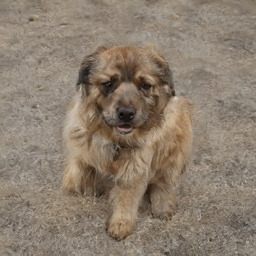

In [114]:
import PIL.Image

pil_img = PIL.Image.fromarray(img.cpu().numpy().squeeze(), 'RGB')

# Display the image
pil_img

#### Save the image

In [ ]:
from pathlib import Path

fname = Path(network_pkl).name.replace('.pkl', '.jpg')
pil_img.save(fname)

### Generate random images

In [ ]:
%cd /content/

In [ ]:
num_images = 10

#### Without truncation

In [ ]:
!python stylegan2-ada-pytorch/generate.py \
 --network={network_pkl} \
 --outdir=out \
 --trunc=1.0 \
 --seeds=0-{num_images-1}

#### With truncation

In [ ]:
!python stylegan2-ada-pytorch/generate.py \
 --network={network_pkl} \
 --outdir=out \
 --trunc=0.5 \
 --seeds=0-{num_images-1}

### Style Mixing

In [ ]:
%cd /content/

#### Without truncation

In [ ]:
!python stylegan2-ada-pytorch/style_mixing.py \
 --network={network_pkl} \
 --outdir=out \
 --trunc=1.0 \
 --rows=1,41,208,322,424,939 \
 --cols=1,41,208,322,424,939

#### With truncation

In [ ]:
!python stylegan2-ada-pytorch/style_mixing.py \
 --network={network_pkl} \
 --outdir=out \
 --trunc=0.5 \
 --rows=1,41,208,322,424,939 \
 --cols=1,41,208,322,424,939

### Projection of real images to latent space

Reference: https://github.com/NVlabs/stylegan2-ada-pytorch#projecting-images-to-latent-space

In [ ]:
%cd /content/

#### Target Steam appIDs

In [ ]:
target_image_app_ids = [
                        1315040, # My UnReal Pet
                        1113080, # Dog Trainer
                        ]

#### Download and resize

##### Define utility functions (tailored for Steam)

In [ ]:
def get_img_folder():
  img_folder = 'img/'
  %mkdir -p {img_folder}

  return img_folder

In [ ]:
from pathlib import Path
from PIL import Image

def download_and_resize_app_ids(target_image_app_ids):
  url = 'https://cdn.cloudflare.steamstatic.com/steam/apps'
  banner_name = 'library_600x900.jpg'
  target_size = (256, 256)

  num_images = len(target_image_app_ids)

  for i, app_id in enumerate(target_image_app_ids, start=1): 
    input_name = get_img_folder() + f'downloaded_img_{app_id}.jpg'
    output_name = get_img_folder() + f'target_img_{app_id}.jpg'

    if not Path(input_name).exists():
      print(f'[{i}/{num_images}] Download image for appID = {app_id}')
      !wget -O {input_name} {url}/{app_id}/{banner_name}

    if not Path(input_name).exists():
      print(f'Image could not be downloaded for appID = {app_id}')
      continue

    if not Path(output_name).exists():
      print(f'[{i}/{num_images}] Resize image for appID = {app_id}')

      try:
        input_img = Image.open(input_name)
      except Image.UnidentifiedImageError:
        input_img = None
        print(f'Input image could not be opened for appID = {app_id}')
        continue
      
      output_img = input_img.resize(target_size, Image.LANCZOS)
      output_img.save(output_name)

  return

##### Run

In [ ]:
download_and_resize_app_ids(target_image_app_ids)

#### Constrain to a single appID (for debugging purpose)

In [ ]:
# target_image_app_ids = [ target_image_app_ids[-1] ]

#### Project

In [ ]:
def get_app_id_folder(app_id):
  output_folder = 'out/{}'.format(app_id)
  %mkdir -p {output_folder}

  return output_folder

In [ ]:
from pathlib import Path

num_images = len(target_image_app_ids)

for i, app_id in enumerate(target_image_app_ids, start=1):
  input_image = get_img_folder() + f'target_img_{app_id}.jpg'

  if not Path(input_image).exists():
    print(f'Target image could not be found for appID = {app_id}')
    continue

  output_folder = get_app_id_folder(app_id)
  output_name = output_folder + '/projected_w.npz'

  if not Path(output_name).exists():
    print(f'[{i}/{num_images}] Project target image for appID = {app_id}')

    !python stylegan2-ada-pytorch/projector.py \
     --network={network_pkl} \
     --outdir={output_folder} \
     --save-video=true \
     --target={input_image}

#### Display

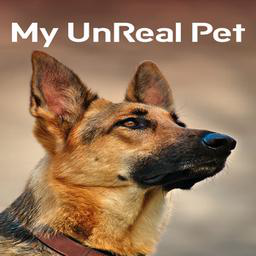

In [110]:
import PIL.Image

app_id = target_image_app_ids[0]
PIL.Image.open(get_app_id_folder(app_id) + '/target.png')

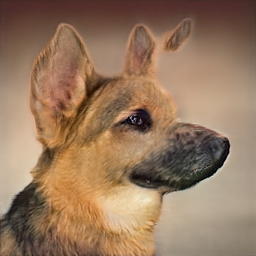

In [111]:
PIL.Image.open(get_app_id_folder(app_id) + '/proj.png')

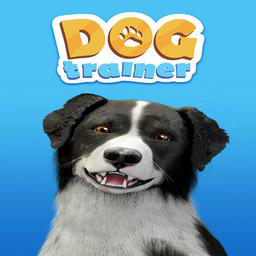

In [112]:
app_id = target_image_app_ids[1]
PIL.Image.open(get_app_id_folder(app_id) + '/target.png')

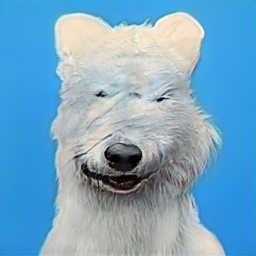

In [113]:
PIL.Image.open(get_app_id_folder(app_id) + '/proj.png')

#### Generate after projection

In [ ]:
dummy_seed = 0

for app_id in target_image_app_ids:
  print('AppID: {}'.format(app_id))

  input_latent_vector = get_app_id_folder(app_id) + '/projected_w.npz'

  output_folder = 'out/image_from_latent_vector'
  %mkdir -p {output_folder}

  !python stylegan2-ada-pytorch/generate.py \
   --network={network_pkl} \
   --outdir={output_folder} \
   --trunc=1 \
   --seeds={dummy_seed} \
   --projected-w={input_latent_vector}